# Import needed packages and vectors

In [6]:
# from core import readfiles
import numpy as np
import os
import multiprocessing as mul
import matplotlib.pyplot as plt
from numba import jit, njit, prange, set_num_threads, vectorize, guvectorize, cuda
from tqdm import tqdm
from core.signal_bag import *
from core.stacking_analysis import *
from core.req_vectors import *
import pickle
import scipy.stats as st
import scipy.interpolate as interp
# import torch
# from core import weights

In [24]:
print(lhsaao1name)

['1LHAASOJ0007+5659u  ', '1LHAASOJ0007+7303u', '1LHAASOJ0056+6346u', '1LHAASOJ0206+4302u', '1LHAASOJ0212+4254u', '1LHAASOJ0216+4237u', '1LHAASOJ0249+6022', '1LHAASOJ0339+5307', '1LHAASOJ0343+5254u*', '1LHAASOJ0359+5406', '1LHAASOJ0428+5531*', '1LHAASOJ0534+3533', '1LHAASOJ0534+2200u', '1LHAASOJ0542+2311u', '1LHAASOJ0622+3754', '1LHAASOJ0631+1040', '1LHAASOJ0634+1741u', '1LHAASOJ0635+0619', '1LHAASOJ0703+1405 ', '1LHASSOJ1809-1918u', '1LHAASOJ1740+0948u ', '1LHASSOJ1813-1245', '1LHAASSOJ1814-1719u*', '1LHAASOJ1814-1636u', '1LHAASOJ1825-1418', ' 1LHAASO J1825-1256u ', '1LHAASOJ1825-1337u', '1LHAASOJ1831-1007u*', '1LHAASOJ1831-1028', '1LHAASOJ1834-0831', '1LHAASOJ1837-0654u', '1LHAASOJ1839-0548u', '1LHAASOJ1841-0519', '1LHAASOJ1843-0335u', '1LHAASOJ1848-0153u', '1LHAASOJ1848-0001u', '1LHAASOJ1850-0004u*', '1LHAASOJ1852+0050u*', '1LHAASOJ1857+0203u', '1LHAASOJ1858+0330', '1LHAASOJ1908+0615u ', '1LHAASOJ1910+0516*', '1LHAASOJ1912+1014u', '1LHAASOJ1913+0501', ' 1LHAASO J1914+1150u ', '1LHAAS

In [7]:
from numba import jit, njit, prange, set_num_threads, vectorize
from numba.experimental import jitclass

In [8]:
from matplotlib.ticker import MaxNLocator, NullLocator,AutoMinorLocator
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import ScalarFormatter

In [10]:
from scipy.optimize import curve_fit
from lmfit.models import GaussianModel


# check the shape of the source list

In [95]:
print(icra.shape)
print(hess_ra.shape)
print(icdec.shape)
print(icetrackdec.shape)
print(len(icetrackdeng))

(1134450,)
(95,)
(1134450,)
(275,)
275


# concatenate the  LHAASO and HESS  vectors

In [6]:
gammaraysrc1ra=np.concatenate([lhsaao1ra, hess_ra], 0)
gammaraysrc1dec=np.concatenate([lhsaao1dec, hess_dec], 0)
gammaraysrc1name=lhsaao1name+hess_name
gammaraysrc2ra=np.concatenate([lhsaao2ra, hess_ra], 0)
gammaraysrc2name=lhsaao2name+hess_name
gammaraysrc2dec=np.concatenate([lhsaao2dec, hess_dec], 0)
# icra=np.hstack([icra,icetrackra])

# icdec=np.hstack([icdec,icetrackdec])
# icang=np.hstack([icang,icetrackdeng])

print(icdec.shape,icang.shape,icra.shape,gammaraysrc1ra.shape)

(1134450,) (1134450,) (1134450,) (170,)


In [8]:
print(gammaraysrc1name[118])

 HESS J1912+101


# see the  machine configurations

In [9]:
num_threads = int(mul.cpu_count()*0.9)
set_num_threads(num_threads)

# Compute the signal PDF for all neutrinos as per eqns 6, 7 and weights as per eqn 8 of 2205.15963

In [10]:


@njit(nogil=True)
def S_ijk(i,nu): 

    '''
    Calculates S_ij as in EQN 7 of 2205.15963
    ----------

    Parameters
    ----------
    nu : int
        Index of the neutrino in the sample
        
    
    Returns
    -------
        Returns the signal PDF for the {psrno}th pulsar and nuind_inp neutrino
    '''
    ang2 = hvovec(gammaraysrc1ra[i], gammaraysrc1dec[i], icra[nu], icdec[nu], rad=True) ** 2      #rad**2
    sg = np.deg2rad(icang[nu]) ** 2                                     #rad**2
    return np.divide(np.exp(-1 * np.divide(ang2, 2*sg)), (2 * np.pi * sg))      #1/rad**2

# @jit(nopython=True)
@vectorize(['float64(int64)'], nopython=True,target='parallel')
def Bi_single_compute(i):

    '''
    Calculates B_i as in EQN 9 of 2205.15963
    ----------

    Parameters
    ----------
    nu : int
        Index of the neutrino from IceCube sample
    cone : float
        Cone angle in degrees.
    

    Returns
    -------
    float
        Returns the background PDF for the {nu}th neutrino
    '''

    # count = np.sum(np.abs(np.subtract(icdec, icdec[nu])) <= cone)
    # count=0
    # for n in prange(len(icdec)):
    #     if abs(icdec[n] - lhsaao1dec[i]) <= 5:
    #         count+=1
    binwidth = (np.sin(np.deg2rad(gammaraysrc1dec[i] + 5)) - np.sin(np.deg2rad(gammaraysrc1dec[i] - 5)))*2*np.pi
    return 1/binwidth           #No units or sr**-1

###  define the  founction of  likelihood function and TS function

In [99]:
@jit(nopython=True)
def Pr(x, Ns, S, B):
    nsN = x/Ns
    return np.add(np.multiply(nsN , S), np.multiply(np.subtract(1, nsN), B))



@njit(nogil=True)
# d@njit(nogil=True)
def TS_st_vec(x, S, B, Ns):
    nsN = x/Ns
    pr = np.add(np.multiply(nsN , S), np.multiply(np.subtract(1, nsN), B))
    return np.sum(np.asfarray(2*np.log10(pr/B)))

lnu = 1134450
Ns = lnu#np.count_nonzero(nuind+1)

#### define the function of the $\chi^{2}$ for fitness

In [100]:
def calc_chisquare(meas, sigma, fit): 
    diff = pow(meas-fit, 2.)
    test_statistic = (diff / pow(sigma,2.)).sum()
    return  test_statistic

### Calculation of the TS values for all  gamma-ray sources

In [101]:
#lenic=1134450
Ts_max=[]
C=[]
for i in prange(len(gammaraysrc1ra)):
    Ts_vec=[]
    S_i=[]

    count_in_decl=0
    for n in prange(len(icdec)):
        if abs(icdec[n] - gammaraysrc1dec[i]) <= 5:
            count_in_decl+=1
            S_i.append(S_ijk(i,n))
    S_i=np.array(S_i)
    #solid_angle=(np.sin(np.deg2rad(lhsaao1dec[i] + 5)) - np.sin(np.deg2rad(lhsaao1dec[i] - 5)))*2*np.pi
    #B_i=count/(solid_angle * lenic)
    count_arr=[i for i in range(count_in_decl)]
    print
    B_i=Bi_single_compute(i)
    #print(B_i)
    # P_i=Pr(count,Ns,S_i,B_i)
#     ns=np.zeros(count)
   
    for c in prange(len(count_arr)):

        # P_i=[]
        # for j in range(len(S_i)):
        #     Pi=Pr(count_arr[c],Ns,S_i[j],B_i)
        #     Pi=2*np.log10(Pi/B_i)
        #     P_i.append(Pi)
        #Ts=np.sum(P_i)
        # print(count_arr[c],S_i[1],B_i,Ns)
        # ns[c]= c
        # P_i=(c/count)*S_i+(1-c/count)*B_i
        # Lns[c]=np.prod(P_i)
        # Ts_vec=TS_st_vec()
        Ts=TS_st_vec(c+1,S_i,B_i,Ns)
        Ts_vec.append(Ts)
    Ts_vec= [a_ for a_ in Ts_vec if a_ == a_]

    C.append(count_arr[np.argmax(Ts_vec)])
    Ts_max.append(Ts_vec[np.argmax(Ts_vec)])
if os.path.exists('Ts_max.txt'):
    os.remove('Ts_max.txt')
    
with open ('Ts_max.txt','a+') as f:
     #Ts.append
    for i in range(len(Ts_max)):
        f.write(str(C[i]))
        f.write('   ')
        f.write(str(Ts_max[i]))
        f.write('\n')
    f.close()

KeyboardInterrupt: 

### Load the  calculated TS values

In [4]:
import numpy as  np
Ts_max=np.loadtxt('Ts_max.txt',usecols=(1),dtype=float)
print(Ts_max)

[-1.18729967e-03  1.93154841e-02  5.24200152e-02 -3.46506734e-03
 -3.48099871e-04 -8.33482603e-03  3.51303548e-02 -1.29023138e-03
  1.67328226e-01 -7.30851134e-04  2.84492983e-01 -4.89934066e-03
 -1.30306600e-03 -8.77589368e-03 -8.75925856e-03  2.78437765e-03
 -5.20084848e-03  3.38669944e-01  9.50891598e-02  2.32369207e-01
 -3.14164198e-03  5.92379816e-01  5.07056542e-01  6.35775977e-01
 -3.73108273e-03 -1.48333608e-02 -1.42618036e-02 -1.35700301e-02
 -2.29635594e-02  2.24570836e-03  8.11030376e-02 -8.08266345e-03
 -1.62909822e-02 -1.58464788e-02 -3.95242930e-03  5.69000831e-01
  4.26627363e-01  7.25608872e-01  4.28903950e-01  2.05751496e-01
 -6.01977178e-03  7.02248117e-01  6.04893934e-01  5.96297864e-01
 -2.83336494e-03  5.33171620e-04 -1.63841642e-02 -3.10904039e-03
  1.88258263e-01  8.77526335e-02  2.02557428e-02  1.42448728e+00
  2.10644386e-01  2.87574143e-03 -1.95204156e-03  4.25917572e-01
  3.70469876e-01 -3.64021551e-03 -3.24614896e-03  4.28745968e-01
 -8.16812665e-03 -3.37163

#### check the ordered TS values

In [11]:
print(np.sort(Ts_max))

[-2.29635594e-02 -1.99723498e-02 -1.87139498e-02 -1.68510300e-02
 -1.63841642e-02 -1.62909822e-02 -1.58464788e-02 -1.48333608e-02
 -1.45058855e-02 -1.42618036e-02 -1.39692005e-02 -1.38305379e-02
 -1.35700301e-02 -1.31523305e-02 -1.27335143e-02 -1.25949450e-02
 -1.24987640e-02 -1.11127748e-02 -1.08996657e-02 -1.08174446e-02
 -1.07809995e-02 -9.73814000e-03 -9.40045467e-03 -8.86690518e-03
 -8.77589368e-03 -8.75925856e-03 -8.54656914e-03 -8.33482603e-03
 -8.26278554e-03 -8.16812665e-03 -8.11328858e-03 -8.08266345e-03
 -7.99924150e-03 -7.44273848e-03 -7.01482616e-03 -6.81153156e-03
 -6.46013352e-03 -6.22333533e-03 -6.01977178e-03 -5.94698944e-03
 -5.77312756e-03 -5.45563823e-03 -5.42014092e-03 -5.20084848e-03
 -5.12323240e-03 -4.96541392e-03 -4.89934066e-03 -4.80243249e-03
 -4.44658526e-03 -4.19749029e-03 -4.10528476e-03 -4.09620307e-03
 -4.08952803e-03 -4.01937651e-03 -3.98156068e-03 -3.95242930e-03
 -3.90433234e-03 -3.73108273e-03 -3.67705513e-03 -3.64021551e-03
 -3.46506734e-03 -3.39536

In [12]:
import math

def percentile(data, perc: int):
    size = len(data)
    return sorted(data)[int(math.ceil((size * perc) / 100)) - 1]

print(percentile([10.0, 1.0], 80))
print(np.percentile(Ts_max,0.000000000000002))
# 9.0
# percentile([142, 232, 290, 120, 274, 123, 146, 113, 272, 119, 124, 277, 207], 2)
# 146

10.0
-0.022963559374714577


#### remove the nan values from the TS vector and show its length

In [13]:
Ts_max= [a_ for a_ in Ts_max if a_ == a_]
print(len(Ts_max))

170


### convert TS vector to numpy array

In [14]:
Ts_max=np.array(Ts_max)
print(Ts_max[0])


-0.001187299670599866


In [15]:
np.where(Ts_max == 4.597064963983218)[0]

array([138])

In [18]:
gamma1st=Ts_max[np.where(Ts_max==4.59706496e+00)]
print(gamma1st)

[]


### check the nan value in the Tsmax array and remove them 

In [16]:
Ts_max=np.array(Ts_max)
# Ts_max=Ts_max.pop('nan')
Ts_max = Ts_max[~np.isnan(Ts_max)]
print(len(Ts_max))

170


### calculate the sqrt of Ts_mac and remove nan in it

In [17]:
Ts_max=np.sqrt(Ts_max)
Ts_max = Ts_max[~np.isnan(Ts_max)]
print(np.sort(Ts_max))

[0.0178462  0.02309051 0.03233019 0.03303114 0.04738891 0.0527672
 0.05362594 0.05503051 0.08169375 0.11939017 0.12909579 0.13898016
 0.14232267 0.16232659 0.18331653 0.18743093 0.19666945 0.20035594
 0.22895418 0.27306035 0.28478595 0.29623071 0.30723253 0.3083653
 0.30968297 0.32502539 0.32508642 0.32632323 0.3341624  0.34680658
 0.37246192 0.38953455 0.40447663 0.40905773 0.43388739 0.43822937
 0.4492764  0.45359839 0.45896011 0.48204689 0.48808576 0.51897926
 0.53337884 0.55949253 0.58195356 0.59480804 0.60468957 0.60866237
 0.65262361 0.65316718 0.65478696 0.65490759 0.71207903 0.71654066
 0.73171946 0.75432144 0.76966214 0.77220325 0.77774927 0.79735562
 0.83064958 0.83800246 0.84597847 0.84679998 0.85182678 0.85469873
 0.92009969 0.94400813 1.03573031 1.09485585 1.11963239 1.19351886
 1.30774279 1.35292813 1.56236411 2.14407672]


/var/folders/2c/m969qfc90tv80w3gmnb7x8r80000gn/T/ipykernel_71296/3489200325.py:1: RuntimeWarning: invalid value encountered in sqrt
  Ts_max=np.sqrt(Ts_max)


# Calulate the pretrial and post-trial values and their corresponding confidence levels for the  four with maximum p values

## calculate the percentiles of max values in TS_max vector(pre-trail values)

In [172]:
import numpy as np
from scipy import stats

# Array and the value for which we want to find the percentile
# array = np.array([0.0178462, 0.02309051, 0.03233019, 0.03303114, 0.04738891, 0.0527672,
#                   0.05362594, 0.05503051, 0.08169375, 0.11939017, 0.12909579, 0.13898016,
#                   0.14232267, 0.16232659, 0.18331653, 0.18743093, 0.19666945, 0.20035594,
#                   0.22895418, 0.27306035, 0.28478595, 0.29623071, 0.30723253, 0.3083653,
#                   0.30968297, 0.32502539, 0.32508642, 0.32632323, 0.3341624, 0.34680658,
#                   0.37246192, 0.38953455, 0.40447663, 0.40905773, 0.43388739, 0.43822937,
#                   0.4492764, 0.45359839, 0.45896011, 0.48204689, 0.48808576, 0.51897926,
#                   0.53337884, 0.55949253, 0.58195356, 0.59480804, 0.60468957, 0.60866237,
#                   0.65262361, 0.65316718, 0.65478696, 0.65490759, 0.71207903, 0.71654066,
#                   0.73171946, 0.75432144, 0.76966214, 0.77220325, 0.77774927, 0.79735562,
#                   0.83064958, 0.83800246, 0.84597847, 0.84679998, 0.85182678, 0.85469873,
#                   0.92009969, 0.94400813, 1.03573031, 1.09485585, 1.11963239, 1.19351886,
#                   1.30774279, 1.35292813, 1.56236411, 2.14407672])

# value = 2.14407672

# Calculate the percentile
percentile = stats.percentileofscore(Ts_max, 4.59706496e+00, kind='weak')
print(percentile-100)

-0.5882352941176379


### define the  CDF for confidence level of  pre-trial values

In [18]:
from scipy.integrate import quad
coff=1/np.sqrt(2*np.pi)
def integrand(z):
	# return(x+1)/x**2
    f=lambda z: np.exp((z**2)*0.5*-1)
    I=quad(f, -1*z, z)[0]
    return I*coff*100
# confidence_level=integrand(99.41176470588236)
# print(confidence_level)
pro=integrand(0.484)
print(pro)

37.16141308786967


### calculate the post-trail values

In [218]:
p_post=1-(1-0.0058)**170
print(1-p_post)

0.37199662227131813


### calculate the confidence level of the post-trial values for the max Ts values in TS_max vector

In [233]:
import numpy as np
from scipy import stats

# Array and the value for which we want to find the percentile
# array = np.array([0.0178462, 0.02309051, 0.03233019, 0.03303114, 0.04738891, 0.0527672,
#                   0.05362594, 0.05503051, 0.08169375, 0.11939017, 0.12909579, 0.13898016,
#                   0.14232267, 0.16232659, 0.18331653, 0.18743093, 0.19666945, 0.20035594,
#                   0.22895418, 0.27306035, 0.28478595, 0.29623071, 0.30723253, 0.3083653,
#                   0.30968297, 0.32502539, 0.32508642, 0.32632323, 0.3341624, 0.34680658,
#                   0.37246192, 0.38953455, 0.40447663, 0.40905773, 0.43388739, 0.43822937,
#                   0.4492764, 0.45359839, 0.45896011, 0.48204689, 0.48808576, 0.51897926,
#                   0.53337884, 0.55949253, 0.58195356, 0.59480804, 0.60468957, 0.60866237,
#                   0.65262361, 0.65316718, 0.65478696, 0.65490759, 0.71207903, 0.71654066,
#                   0.73171946, 0.75432144, 0.76966214, 0.77220325, 0.77774927, 0.79735562,
#                   0.83064958, 0.83800246, 0.84597847, 0.84679998, 0.85182678, 0.85469873,
#                   0.92009969, 0.94400813, 1.03573031, 1.09485585, 1.11963239, 1.19351886,
#                   1.30774279, 1.35292813, 1.56236411, 2.14407672])

# value = 2.14407672

# Calculate the percentile
percentile = stats.percentileofscore(Ts_max, 1.83041454e+00, kind='weak')
print(percentile-100)

from scipy.integrate import quad
coff=1/np.sqrt(2*np.pi)
def integrand(z):
	# return(x+1)/x**2
    f=lambda z: np.exp((z**2)*0.5*-1)
    I=quad(f, -1*z, z)[0]
    return I*coff*100
# confidence_level=integrand(99.41176470588236)
# print(confidence_level)
pro=integrand(2.5)
print(pro)

p_post=1-(1-0.0117647058823529)**170
print(p_post)
print(p_post*100-100)
pro_post=integrand(0.17)
print(pro_post)

-1.17647058823529
98.75806693484479
0.8662600184071927
-13.373998159280731
13.498986335007684


### calculation of the second highest pre and post -trial values and their confidence levels

In [237]:
import numpy as np
from scipy import stats

# Array and the value for which we want to find the percentile
# array = np.array([0.0178462, 0.02309051, 0.03233019, 0.03303114, 0.04738891, 0.0527672,
#                   0.05362594, 0.05503051, 0.08169375, 0.11939017, 0.12909579, 0.13898016,
#                   0.14232267, 0.16232659, 0.18331653, 0.18743093, 0.19666945, 0.20035594,
#                   0.22895418, 0.27306035, 0.28478595, 0.29623071, 0.30723253, 0.3083653,
#                   0.30968297, 0.32502539, 0.32508642, 0.32632323, 0.3341624, 0.34680658,
#                   0.37246192, 0.38953455, 0.40447663, 0.40905773, 0.43388739, 0.43822937,
#                   0.4492764, 0.45359839, 0.45896011, 0.48204689, 0.48808576, 0.51897926,
#                   0.53337884, 0.55949253, 0.58195356, 0.59480804, 0.60468957, 0.60866237,
#                   0.65262361, 0.65316718, 0.65478696, 0.65490759, 0.71207903, 0.71654066,
#                   0.73171946, 0.75432144, 0.76966214, 0.77220325, 0.77774927, 0.79735562,
#                   0.83064958, 0.83800246, 0.84597847, 0.84679998, 0.85182678, 0.85469873,
#                   0.92009969, 0.94400813, 1.03573031, 1.09485585, 1.11963239, 1.19351886,
#                   1.30774279, 1.35292813, 1.56236411, 2.14407672])

# value = 2.14407672

# Calculate the percentile
percentile = stats.percentileofscore(Ts_max, 1.83041454e+00, kind='weak')
print(percentile-100)

from scipy.integrate import quad
coff=1/np.sqrt(2*np.pi)
def integrand(z):
	# return(x+1)/x**2
    f=lambda z: np.exp((z**2)*0.5*-1)
    I=quad(f, -1*z, z)[0]
    return I*coff*100
# confidence_level=integrand(99.41176470588236)
# print(confidence_level)
pro=integrand(2.5)
print(pro)

p_post=1-(1-0.0117647058823529)**170
print(p_post)
print(p_post*100-100)
pro_post=integrand(0.17)
print(pro_post)

-1.17647058823529
98.75806693484479
0.8662600184071927
-13.373998159280731
13.498986335007684


### calculation of the third highest pre and post -trial values and their confidence levels

In [40]:
import numpy as np
from scipy import stats

# Array and the value for which we want to find the percentile
# array = np/
# .array([0.0178462, 0.02309051, 0.03233019, 0.03303114, 0.04738891, 0.0527672,
#                   0.05362594, 0.05503051, 0.08169375, 0.11939017, 0.12909579, 0.13898016,
#                   0.14232267, 0.16232659, 0.18331653, 0.18743093, 0.19666945, 0.20035594,
#                   0.22895418, 0.27306035, 0.28478595, 0.29623071, 0.30723253, 0.3083653,
#                   0.30968297, 0.32502539, 0.32508642, 0.32632323, 0.3341624, 0.34680658,
#                   0.37246192, 0.38953455, 0.40447663, 0.40905773, 0.43388739, 0.43822937,
#                   0.4492764, 0.45359839, 0.45896011, 0.48204689, 0.48808576, 0.51897926,
#                   0.53337884, 0.55949253, 0.58195356, 0.59480804, 0.60468957, 0.60866237,
#                   0.65262361, 0.65316718, 0.65478696, 0.65490759, 0.71207903, 0.71654066,
#                   0.73171946, 0.75432144, 0.76966214, 0.77220325, 0.77774927, 0.79735562,
#                   0.83064958, 0.83800246, 0.84597847, 0.84679998, 0.85182678, 0.85469873,
#                   0.92009969, 0.94400813, 1.03573031, 1.09485585, 1.11963239, 1.19351886,
#                   1.30774279, 1.35292813, 1.56236411, 2.14407672])

# value = 2.14407672

# Calculate the percentile
percentile = stats.percentileofscore(Ts_max, 1.71019119e+00, kind='weak')
print(percentile-100)

from scipy.integrate import quad
coff=1/np.sqrt(2*np.pi)
def integrand(z):
	# return(x+1)/x**2
    f=lambda z: np.exp((z**2)*0.5*-1)
    I=quad(f, -1*z, z)[0]
    return I*coff*100
# confidence_level=integrand(99.41176470588236)
# print(confidence_level)
pro=integrand(2.2647)
print(pro)

p_post=1-(1-2.35294117647058e-2)**170
print(p_post)
print(p_post*100-100)
pro_post=integrand(0.0219)
print(pro_post)

-1.3157894736842053
97.64689045114773
0.9825394334026578
-1.7460566597342222
1.7472275224100022


## define guassian function

In [20]:
def gauss1(x, H,A, x0, sigma):
    return  H +A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))
def gauss(x,A,x0, sigma):
    return   A* np.exp(-(x-x0) ** 2 / (2 * sigma ** 2))

## plot the TS_max distribution with Guassian fit

[0.0178462  0.23046926 0.44309231 0.65571536 0.86833841 1.08096146
 1.29358451 1.50620756 1.71883061 1.93145366 2.14407672] 
 <BarContainer object of 10 artists>
[0.12415773 0.33678078 0.54940383 0.76202688 0.97464993 1.18727299
 1.39989604 1.61251909 1.82514214 2.03776519] 
 [19. 17. 16. 14.  3.  3.  2.  1.  0.  1.]


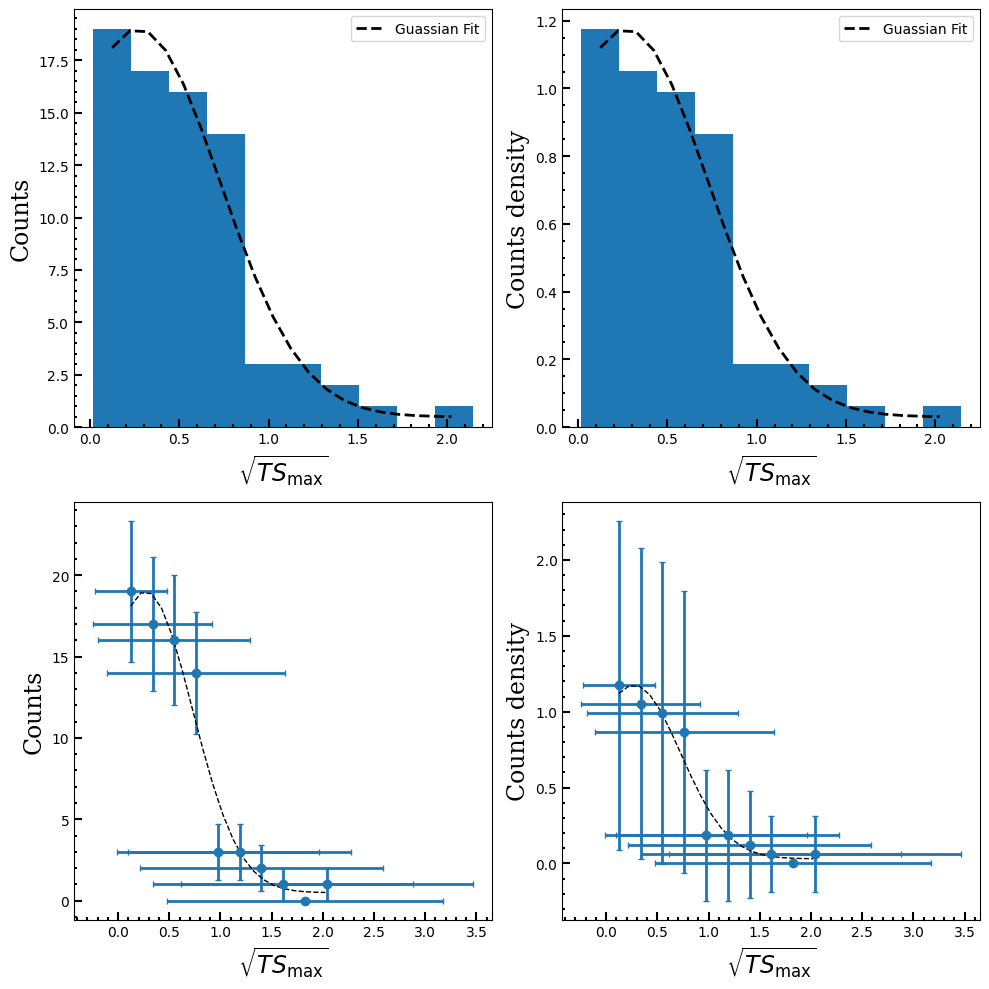

In [23]:
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import MaxNLocator, NullLocator
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
font = {'family': 'serif',
        'weight': 'bold',
        'size': 22,
        'color':  'black',
        }
smallerfont = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 15,
        }

axesfont = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 17,
        }
n_bins = 10
fig, axs = plt.subplots(2, 2, tight_layout=True,figsize=(10, 10))
axs[0][0].set_ylabel('Counts',axesfont)
axs[0][0].set_xlabel(r'$\sqrt{TS_{\rm max}}$',axesfont)
axs[1][0].set_ylabel('Counts',axesfont)
axs[1][0].set_xlabel(r'$\sqrt{TS_{\rm max}}$',axesfont)

# N is the count in each bin, bins is the lower-limit of the bin
N, bins, patches = axs[0][0].hist(Ts_max, bins=n_bins,linewidth=3)
print(bins,'\n',patches)
xdata=(bins[:-1]+bins[1:])*0.5
ydata=N
xplot=np.arange(min(xdata)-0.00001,max(xdata),0.1)

print(xdata,'\n',ydata)
# We'll color code by height, but you could use any scalar
parameters, covariance = curve_fit(gauss1, xdata, ydata,maxfev=5000000)
# parameters1,covariance1=curve_fit(gauss,xdata, ydata,maxfev=500000)
# fit_A = parameters[0]
# fit_B = parameters[1]

fit_y = gauss1(xplot, *parameters)

# axs[0].plot(xplot, fit_y, '--', label='fit',c='green')
axs[0][0].plot(xplot, fit_y, '--', label='Guassian Fit',c='k',linewidth=2)
axs[1][0].errorbar(xdata, ydata, xerr=np.sqrt(xdata), yerr=np.sqrt(ydata), fmt='o', elinewidth=2,capsize=2)
axs[1][0].plot(xplot, fit_y, '--', label='Guassian Fit',c='k',linewidth=1)
fracs = N / N.max()

# we need to normalize the data to 0..1 for the full range of the colormap
norm = colors.Normalize(fracs.min(), fracs.max())

# Now, we'll loop through our objects and set the color of each accordingly
# for thisfrac, thispatch in zip(fracs, patches):
#     color = plt.cm.viridis(norm(thisfrac))
#     thispatch.set_facecolor(color)

# We can also normalize our inputs by the total number of counts
N1, bins1, patches1 = axs[0][1].hist(Ts_max, bins=n_bins, density=True)
axs[0][1].set_ylabel('Counts density',axesfont)
axs[0][1].set_xlabel(r'$\sqrt{TS_{\rm max}}$',axesfont)
axs[1][1].set_ylabel('Counts density',axesfont)
axs[1][1].set_xlabel(r'$\sqrt{TS_{\rm max}}$',axesfont)
xdata1=(bins[:-1]+bins[1:])*0.5
ydata1=N1
xplot1=np.arange(min(xdata1)-0.00001,max(xdata1),0.1)
parameters1,covariance1=curve_fit(gauss1,xdata1, ydata1,maxfev=500000)
fit_y1=gauss1(xplot1, *parameters1)

axs[0][1].plot(xplot1, fit_y1, '--', label='Guassian Fit',c='k',linewidth=2)
axs[1][1].errorbar(xdata1, ydata1, xerr=np.sqrt(xdata1), yerr=np.sqrt(ydata1), fmt='o', elinewidth=2,capsize=2)
axs[1][1].plot(xplot1, fit_y1, '--', label='Guassian Fit',c='k',linewidth=1)
# Now we format the y-axis to display percentage
#axs[1].yaxis.set_major_formatter(PercentFormatter(xmax=1))
axs[0][0].tick_params(which='major', width=1.5, length=6,direction='in')
axs[0][0].tick_params(which='minor', width=1.5, length=3,direction='in')
axs[0][1].tick_params(which='major', width=1.5, length=6,direction='in')
axs[0][1].tick_params(which='minor', width=1.5, length=3,direction='in')
axs[1][0].tick_params(which='major', width=1.5, length=6,direction='in')
axs[1][0].tick_params(which='minor', width=1.5, length=3,direction='in')
axs[1][1].tick_params(which='major', width=1.5, length=6,direction='in')
axs[1][1].tick_params(which='minor', width=1.5, length=3,direction='in')
#axs[1].xaxis.set_minor_locator(MultipleLocator(5))
axs[0][0].legend()
# axs[1].xaxis.set_minor_locator(MultipleLocator(5))
axs[0][1].legend()
axs[0][0].xaxis.set_minor_locator(AutoMinorLocator())
axs[0][0].yaxis.set_minor_locator(AutoMinorLocator())
axs[0][0].tick_params(which='minor', length=2, color='k')
# For the minor ticks, use no labels; default NullFormatter.
axs[0][1].xaxis.set_minor_locator(AutoMinorLocator())
axs[0][1].yaxis.set_minor_locator(AutoMinorLocator())
axs[0][1].tick_params(which='minor', length=2, color='k')
axs[1][0].xaxis.set_minor_locator(AutoMinorLocator())
axs[1][0].yaxis.set_minor_locator(AutoMinorLocator())
axs[1][0].tick_params(which='minor', length=2, color='k')
axs[1][1].xaxis.set_minor_locator(AutoMinorLocator())
axs[1][1].yaxis.set_minor_locator(AutoMinorLocator())
axs[1][1].tick_params(which='minor', length=2, color='k')
# axs[1][0].set_xscale('log')
# axs[1][1].set_xscale('log')
# axs[1][0].set_yscale('log')
# axs[1][1].set_yscale('log')
# axs[0][0].set_yscale('log')
# axs[0][1].set_yscale('log')
# axs[0][0].set_xscale('log')
# axs[0][1].set_xscale('log')
fig.savefig('Ts_max_distr.pdf')

## refined plot TS+max distribution for LHAASOWCDA-HESS

[0.0178462  0.21113989 0.40443357 0.59772725 0.79102094 0.98431462
 1.1776083  1.37090198 1.56419567 2.14407672] 
[0.11449305 0.30778673 0.50108041 0.6943741  0.88766778 1.08096146
 1.27425514 1.46754882 1.8541362 ] 
 [18. 14. 14. 13.  9.  3.  3.  1.  1.]
X-axis tick labels: ['', '', '', '', '', '1.00', '', '', '1.75']
Y-axis tick labels: ['', '', '5.0', '', '10.0', '', '15.0', '', '20.0']


/var/folders/2c/m969qfc90tv80w3gmnb7x8r80000gn/T/ipykernel_71296/990866740.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(['', '', '', '', '', '1.00', '', '', '1.75', ''], fontsize=14)  # Set size for x-axis
/var/folders/2c/m969qfc90tv80w3gmnb7x8r80000gn/T/ipykernel_71296/990866740.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_yticklabels(['', '', '5.0', '', '10.0', '', '15.0', '', '20.0'], fontsize=14)


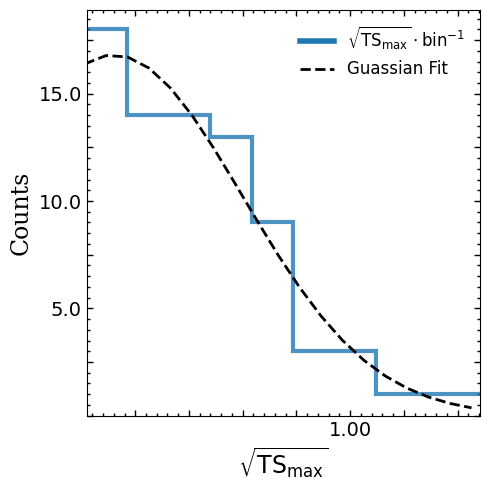

In [36]:
from matplotlib.lines import Line2D
font = {'family': 'serif',
        'weight': 'bold',
        'size': 22,
        'color':  'black',
        }
smallerfont = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 15,
        }

axesfont = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 17,
        }
custom_lines = [Line2D([0], [0], color='#1f77b4', lw=4),
                Line2D([0], [2],linestyle='--', color='k', lw=2)]
n_bins = 11
fig, axs = plt.subplots(1, 1, tight_layout=True,figsize=(5, 5))
axs.set_ylabel('Counts',axesfont)
axs.set_xlabel(r'$\sqrt{{\rm TS_{max}}}$',axesfont)
# axs[1][0].set_ylabel('Counts',axesfont)
# axs[1][0].set_xlabel(r'$\sqrt{TS_{\rm max}}$',axesfont)

# N is the count in each bin, bins is the lower-limit of the bin
N, bins, patches = axs.hist(Ts_max, bins=[0.0178462 ,0.21113989, 0.40443357, 0.59772725, 0.79102094, 0.98431462,
 1.1776083, 1.37090198, 1.56419567, 2.14407672]  ,linewidth=3,histtype='step',stacked=True,alpha=0.8)

print(bins,'\n',patches)
xdata=(bins[:-1]+bins[1:])*0.5
ydata=N
xplot=np.arange(min(xdata)-0.1,max(xdata),0.1)
axs.set_xlim(min(xdata)-0.09,max(xdata))
print(xdata,'\n',ydata)
# We'll color code by height, but you could use any scalar
parameters, covariance = curve_fit(gauss, xdata, ydata,maxfev=5000000)
# parameters1,covariance1=curve_fit(gauss,xdata, ydata,maxfev=500000)
# fit_A = parameters[0]
# fit_B = parameters[1]

fit_y = gauss(xplot, *parameters)

# axs[0].plot(xplot, fit_y, '--', label='fit',c='green')
axs.plot(xplot, fit_y,linestyle='--',c='k',linewidth=2)
# axs[1][0].errorbar(xdata, ydata, xerr=np.sqrt(xdata), yerr=np.sqrt(ydata), fmt='o', elinewidth=2,capsize=2)
# axs[1][0].plot(xplot, fit_y, '--', label='Guassian Fit',c='k',linewidth=1)
# fracs = N / N.max()

# we need to normalize the data to 0..1 for the full range of the colormap
# norm = colors.Normalize(fracs.min(), fracs.max())

# Now, we'll loop through our objects and set the color of each accordingly
# for thisfrac, thispatch in zip(fracs, patches):
#     color = plt.cm.viridis(norm(thisfrac))
#     thispatch.set_facecolor(color)

# We can also normalize our inputs by the total number of counts
# N1, bins1, patches1 = axs[0][1].hist(Ts_max, bins=n_bins, density=True)
# axs[0][1].set_ylabel('Counts density',axesfont)
# axs[0][1].set_xlabel(r'$\sqrt{TS_{\rm max}}$',axesfont)
# axs[1][1].set_ylabel('Counts density',axesfont)
# axs[1][1].set_xlabel(r'$\sqrt{TS_{\rm max}}$',axesfont)
# xdata1=(bins[:-1]+bins[1:])*0.5
# ydata1=N1
# xplot1=np.arange(min(xdata1)-0.00001,max(xdata1),0.1)
# parameters1,covariance1=curve_fit(gauss1,xdata1, ydata1,maxfev=500000)
# fit_y1=gauss1(xplot1, *parameters1)

# axs[0][1].plot(xplot1, fit_y1, '--', label='Guassian Fit',c='k',linewidth=2)
# axs[1][1].errorbar(xdata1, ydata1, xerr=np.sqrt(xdata1), yerr=np.sqrt(ydata1), fmt='o', elinewidth=2,capsize=2)
# axs[1][1].plot(xplot1, fit_y1, '--', label='Guassian Fit',c='k',linewidth=1)
# Now we format the y-axis to display percentage
#axs[1].yaxis.set_major_formatter(PercentFormatter(xmax=1))
axs.tick_params(which='major', width=1.5, length=6,direction='in')
axs.tick_params(which='minor', width=1.5, length=3,direction='in')
# axs[0][1].tick_params(which='major', width=1.5, length=6,direction='in')
# axs[0][1].tick_params(which='minor', width=1.5, length=3,direction='in')
# axs[1][0].tick_params(which='major', width=1.5, length=6,direction='in')
# axs[1][0].tick_params(which='minor', width=1.5, length=3,direction='in')
# axs[1][1].tick_params(which='major', width=1.5, length=6,direction='in')
# axs[1][1].tick_params(which='minor', width=1.5, length=3,direction='in')
# #axs[1].xaxis.set_minor_locator(MultipleLocator(5))
# axs[0][0].legend()
# # axs[1].xaxis.set_minor_locator(MultipleLocator(5))
# axs[0][1].legend()
axs.xaxis.set_minor_locator(AutoMinorLocator())
axs.yaxis.set_minor_locator(AutoMinorLocator())
axs.tick_params(which='minor', length=2,width=1, color='k')
axs.tick_params(which='major', length=4,width=1, color='k')
axs.tick_params(axis='x', which='minor', bottom=True,top=True)
axs.tick_params(axis='x', which='major', bottom=True,top=True)
axs.tick_params(axis='y', which='minor', bottom=True,top=True,right=True)
axs.tick_params(axis='y', which='major', bottom=True,top=True,right=True)
axs.set_xticklabels(['', '', '', '', '', '1.00', '', '', '1.75', ''], fontsize=14)  # Set size for x-axis
axs.set_yticklabels(['', '', '5.0', '', '10.0', '', '15.0', '', '20.0'], fontsize=14) 
# For the minor ticks, use no labels; default NullFormatter.
# axs[0][1].xaxis.set_minor_locator(AutoMinorLocator())
# axs[0][1].yaxis.set_minor_locator(AutoMinorLocator())
# axs[0][1].tick_params(which='minor', length=2, color='k')
# axs[1][0].xaxis.set_minor_locator(AutoMinorLocator())
# axs[1][0].yaxis.set_minor_locator(AutoMinorLocator())
# axs[1][0].tick_params(which='minor', length=2, color='k')
# axs[1][1].xaxis.set_minor_locator(AutoMinorLocator())
# axs[1][1].yaxis.set_minor_locator(AutoMinorLocator())
# axs[1][1].tick_params(which='minor', length=2, color='k')
# axs[1][0].set_xscale('log')
# axs[1][1].set_xscale('log')
# axs[1][0].set_yscale('log')
# axs[1][1].set_yscale('log')
# axs[0][0].set_yscale('log')
# axs[0][1].set_yscale('log')
# axs[0][0].set_xscale('log')
# axs[0][1].set_xscale('log')
x_labels = [tick.get_text() for tick in axs.get_xticklabels()]
y_labels = [tick.get_text() for tick in axs.get_yticklabels()]
print("X-axis tick labels:", x_labels)
print("Y-axis tick labels:", y_labels)
plt.legend(custom_lines,[r'$\sqrt{{\rm TS_{max}}} \cdot{\rm bin^{-1}}$','Guassian Fit'],fancybox=False,edgecolor=None,frameon=False,fontsize='large')
fig.savefig('fig2a.pdf')

 # Compute the signal PDF for all neutrinos

In [190]:

@njit(nogil=True)
def S_ijk(i,nu): 

    '''
    Calculates S_ij as in EQN 7 of 2205.15963
    ----------

    Parameters
    ----------
    nu : int
        Index of the neutrino in the sample
        
    
    Returns
    -------
        Returns the signal PDF for the {psrno}th pulsar and nuind_inp neutrino
    '''
    ang2 = hvovec(gammaraysrc2ra[i], gammaraysrc2dec[i], icra[nu], icdec[nu], rad=True) ** 2      #rad**2
    sg = np.deg2rad(icang[nu]) ** 2                                     #rad**2
    return np.divide(np.exp(-1 * np.divide(ang2, 2*sg)), (2 * np.pi * sg))      #1/rad**2

# @jit(nopython=True)
@vectorize(['float64(int64)'], nopython=True,target='parallel')
def Bi_single_compute(i):

    '''
    Calculates B_i as in EQN 9 of 2205.15963
    ----------

    Parameters
    ----------
    nu : int
        Index of the neutrino from IceCube sample
    cone : float
        Cone angle in degrees.
    

    Returns
    -------
    float
        Returns the background PDF for the {nu}th neutrino
    '''

    # count = np.sum(np.abs(np.subtract(icdec, icdec[nu])) <= cone)
    # count=0
    # for n in prange(len(icdec)):
    #     if abs(icdec[n] - lhsaao1dec[i]) <= 5:
    #         count+=1
    binwidth = (np.sin(np.deg2rad(gammaraysrc2dec[i] + 5)) - np.sin(np.deg2rad(gammaraysrc2dec[i] - 5)))*2*np.pi
    return 1/binwidth           #No units or sr**-1

## define the likelihood and   TS_vec

In [191]:
@jit(nopython=True)
def Pr(x, Ns, S, B):
    nsN = x/Ns
    return np.add(np.multiply(nsN , S), np.multiply(np.subtract(1, nsN), B))



@njit(nogil=True)
# d@njit(nogil=True)
def TS_st_vec(x, S, B, Ns):
    nsN = x/Ns
    pr = np.add(np.multiply(nsN , S), np.multiply(np.subtract(1, nsN), B))
    return np.sum(np.asfarray(2*np.log10(pr/B)))

lnu = 1134450
Ns = lnu#np.count_nonzero(nuind+1)

## calculation of TS_vec and save it in txt

In [ ]:
Ts_max_1=[]
C_1=[]
for i in range(len(gammaraysrc2ra)):
    Ts_vec=[]
    S_i=[]

    count=0
    for n in prange(len(icdec)):
        if abs(icdec[n] - gammaraysrc2dec[i]) <= 5:
            count+=1
            S_i.append(S_ijk(i,n))
    S_i=np.array(S_i)
    #solid_angle=(np.sin(np.deg2rad(lhsaao1dec[i] + 5)) - np.sin(np.deg2rad(lhsaao1dec[i] - 5)))*2*np.pi
    #B_i=count/(solid_angle * lenic)
    count_arr=[i for i in range(count)]
    B_i=Bi_single_compute(i)
    #print(B_i)
    # P_i=Pr(count,Ns,S_i,B_i)
#     ns=np.zeros(count)
   
    for c in prange(len(count_arr)):

        # P_i=[]
        # for j in range(len(S_i)):
        #     Pi=Pr(count_arr[c],Ns,S_i[j],B_i)
        #     Pi=2*np.log10(Pi/B_i)
        #     P_i.append(Pi)
        #Ts=np.sum(P_i)
        # print(count_arr[c],S_i[1],B_i,Ns)
        # ns[c]= c
        # P_i=(c/count)*S_i+(1-c/count)*B_i
        # Lns[c]=np.prod(P_i)
        # Ts_vec=TS_st_vec()
        Ts=TS_st_vec(c+1,S_i,B_i,Ns)
        Ts_vec.append(Ts)
    Ts_vec= [a_ for a_ in Ts_vec if a_ == a_]

    C_1.append(count_arr[np.argmax(Ts_vec)])
    Ts_max_1.append(Ts_vec[np.argmax(Ts_vec)])
if os.path.exists('Ts_max_1.txt'):
    os.remove('Ts_max_1.txt')
    
with open ('Ts_max_1.txt','a+') as f:
     #Ts.append
    for i in range(len(Ts_max_1)):
        f.write(str(C_1[i]))
        f.write('   ')
        f.write(str(Ts_max_1[i]))
        f.write('\n')
    f.close()

In [ ]:
a=[i for i in range(7)]
for i in range(len(a)):
    print(i)

In [337]:
print(gammaraysrc2name[53])
print(np.where(Ts_max_1 == 2.33966878760389))

1LHAASOJ2002+3244u
(array([52]),)


## load the TS_max_1 from txt

In [39]:
Ts_max_1=np.loadtxt('Ts_max_1.txt',usecols=(1))

print(np.sort(Ts_max_1))

[-1.99723498e-02 -1.98834048e-02 -1.87139498e-02 -1.68510300e-02
 -1.55987223e-02 -1.50381926e-02 -1.45058855e-02 -1.43353513e-02
 -1.39692005e-02 -1.38305379e-02 -1.31523305e-02 -1.27335143e-02
 -1.25949450e-02 -1.24987640e-02 -1.24235336e-02 -1.23118952e-02
 -1.11127748e-02 -1.08996657e-02 -1.08174446e-02 -1.07809995e-02
 -1.05332221e-02 -9.73814000e-03 -9.40045467e-03 -8.86690518e-03
 -8.54656914e-03 -8.26278554e-03 -8.11328858e-03 -7.99924150e-03
 -7.58495985e-03 -7.44273848e-03 -7.01482616e-03 -6.86327628e-03
 -6.81153156e-03 -6.46013352e-03 -6.30268940e-03 -6.22333533e-03
 -6.01977178e-03 -5.94698944e-03 -5.77312756e-03 -5.76113962e-03
 -5.61804862e-03 -5.61600500e-03 -5.45563823e-03 -5.42014092e-03
 -5.12962052e-03 -5.12323240e-03 -4.96541392e-03 -4.80243249e-03
 -4.69009562e-03 -4.57142242e-03 -4.44658526e-03 -4.19749029e-03
 -4.10528476e-03 -4.08952803e-03 -4.01937651e-03 -3.90433234e-03
 -3.67705513e-03 -3.30571952e-03 -3.20189445e-03 -3.18274282e-03
 -3.04300475e-03 -3.02113

## calculate the pre-trail and post trial and their confidence levels for the first four highest TS_max

In [41]:
percentile = stats.percentileofscore(Ts_max_1, 2.33966879e+00, kind='weak')
print(percentile-100)

from scipy.integrate import quad
coff=1/np.sqrt(2*np.pi)
def integrand(z):
	# return(x+1)/x**2
    f=lambda z: np.exp((z**2)*0.5*-1)
    I=quad(f, -1*z, z)[0]
    return I*coff*100
# confidence_level=integrand(99.41176470588236)
# print(confidence_level)
pro=integrand(2.3596)
print(pro)

p_post=1-(1-0.018292682926829258)**164
print(p_post)
print(p_post*100-100)
pro_post=integrand(0.061)
print(pro_post)

-1.8292682926829258
98.17053506202407
0.9515768999673596
-4.842310003264032
4.864079094285733


In [335]:
percentile = stats.percentileofscore(Ts_max_1, 2.44098162e+00 , kind='weak')

print(percentile-100)

from scipy.integrate import quad
coff=1/np.sqrt(2*np.pi)
def integrand(z):
	# return(x+1)/x**2
    f=lambda z: np.exp((z**2)*0.5*-1)
    I=quad(f, -1*z, z)[0]
    return I*coff*100
# confidence_level=integrand(99.41176470588236)
# print(confidence_level)
pro=integrand(2.5063)
print(pro)

p_post=1-(1-0.012195121951219505)**164
print(p_post)
print(p_post*100-100)
pro_post=integrand(0.15)
print(pro_post)

-1.2195121951219505
98.7799794340441
0.8663185014872676
-13.36814985127323
11.923538474048504


## remove the nan values in TS_max_1 vectors

In [42]:
Ts_max_1=np.sqrt(Ts_max_1)
Ts_max_1 = Ts_max_1[~np.isnan(Ts_max_1)]

print(np.sort(Ts_max_1))

[0.01747902 0.0178462  0.03233019 0.03303114 0.0354261  0.05503051
 0.08652889 0.11939017 0.12909579 0.15410884 0.15476113 0.18331653
 0.18775882 0.19666945 0.20035594 0.20293686 0.20597991 0.22560652
 0.24190087 0.24536178 0.24573631 0.26567811 0.28534782 0.30723253
 0.30968297 0.31159508 0.31345369 0.32502539 0.32632323 0.3341624
 0.34315673 0.34680658 0.37246192 0.38716655 0.38953455 0.40447663
 0.43822937 0.4492764  0.48808576 0.50409977 0.50896895 0.51897926
 0.55949253 0.57870626 0.58776522 0.59480804 0.60468957 0.60972633
 0.71654066 0.71754302 0.72647019 0.73171946 0.83064958 0.84597847
 0.84679998 0.85469873 0.90901912 1.03573031 1.08611037 1.09485585
 1.09623979 1.11963239 1.18179634 1.30774279 1.33038428 1.35292813
 1.52959759 1.56236411 1.586236   2.14407672]


/var/folders/2c/m969qfc90tv80w3gmnb7x8r80000gn/T/ipykernel_71296/4226464898.py:1: RuntimeWarning: invalid value encountered in sqrt
  Ts_max_1=np.sqrt(Ts_max_1)


## plot the TS_max_1 distribution with Guassian fit

[0.12380891 0.33646868 0.54912844 0.76178821 0.97444798 1.18710775
 1.39976752 1.61242729 1.82508706 2.03774683] 
 [18. 19. 11.  8.  2.  5.  3.  3.  0.  1.]


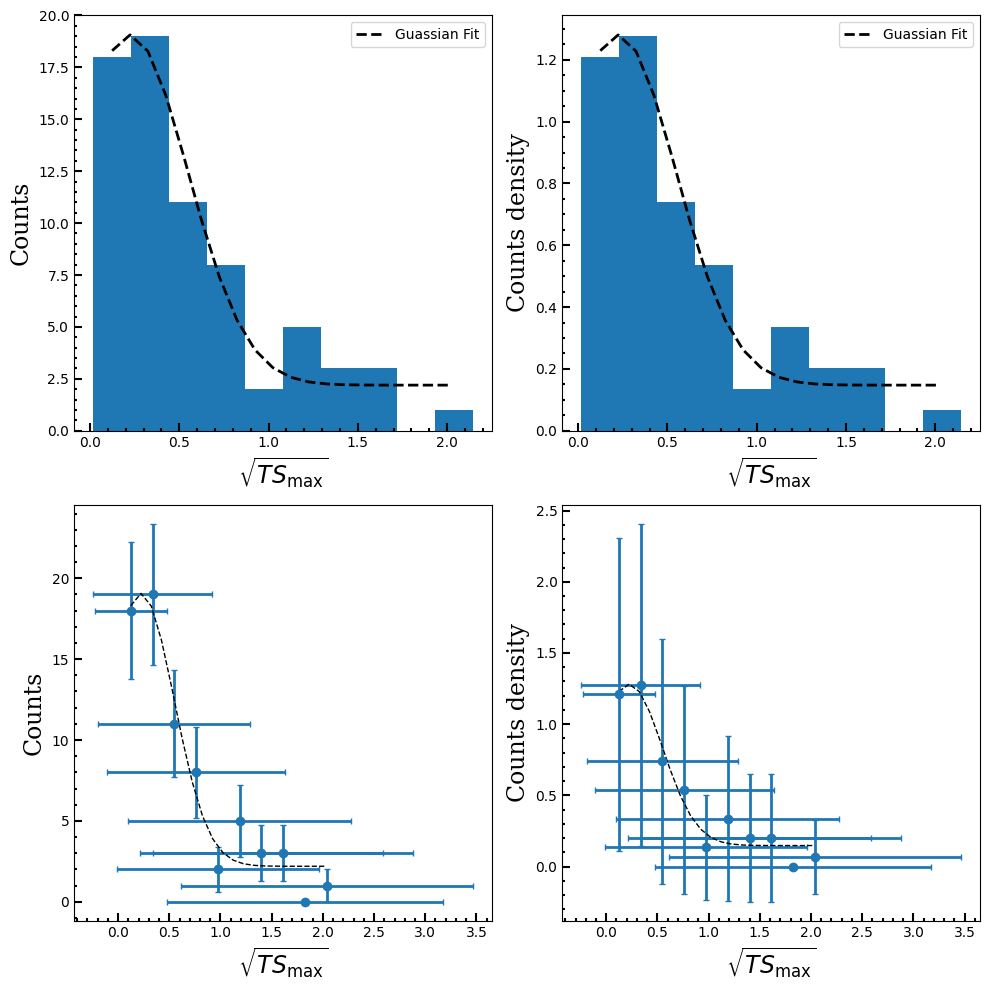

In [43]:
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import MaxNLocator, NullLocator
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
font = {'family': 'serif',
        'weight': 'bold',
        'size': 22,
        'color':  'black',
        }
smallerfont = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 15,
        }

axesfont = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 17,
        }
n_bins = 10
fig, axs = plt.subplots(2, 2, tight_layout=True,figsize=(10, 10))
axs[0][0].set_ylabel('Counts',axesfont)
axs[0][0].set_xlabel(r'$\sqrt{TS_{\rm max}}$',axesfont)
axs[1][0].set_ylabel('Counts',axesfont)
axs[1][0].set_xlabel(r'$\sqrt{TS_{\rm max}}$',axesfont)

# N is the count in each bin, bins is the lower-limit of the bin
N, bins, patches = axs[0][0].hist(Ts_max_1, bins=n_bins,linewidth=3)
#print(bins,'\n',patches)
xdata=(bins[:-1]+bins[1:])*0.5
ydata=N
xplot=np.arange(min(xdata)-0.00001,max(xdata),0.1)

print(xdata,'\n',ydata)
# We'll color code by height, but you could use any scalar
parameters, covariance = curve_fit(gauss1, xdata, ydata,maxfev=5000000)
# parameters1,covariance1=curve_fit(gauss,xdata, ydata,maxfev=500000)
# fit_A = parameters[0]
# fit_B = parameters[1]

fit_y = gauss1(xplot, *parameters)

# axs[0].plot(xplot, fit_y, '--', label='fit',c='green')
axs[0][0].plot(xplot, fit_y, '--', label='Guassian Fit',c='k',linewidth=2)
axs[1][0].errorbar(xdata, ydata, xerr=np.sqrt(xdata), yerr=np.sqrt(ydata), fmt='o', elinewidth=2,capsize=2)
axs[1][0].plot(xplot, fit_y, '--', label='Guassian Fit',c='k',linewidth=1)
fracs = N / N.max()

# we need to normalize the data to 0..1 for the full range of the colormap
norm = colors.Normalize(fracs.min(), fracs.max())

# Now, we'll loop through our objects and set the color of each accordingly
# for thisfrac, thispatch in zip(fracs, patches):
#     color = plt.cm.viridis(norm(thisfrac))
#     thispatch.set_facecolor(color)

# We can also normalize our inputs by the total number of counts
N1, bins1, patches1 = axs[0][1].hist(Ts_max_1, bins=n_bins, density=True)
axs[0][1].set_ylabel('Counts density',axesfont)
axs[0][1].set_xlabel(r'$\sqrt{TS_{\rm max}}$',axesfont)
axs[1][1].set_ylabel('Counts density',axesfont)
axs[1][1].set_xlabel(r'$\sqrt{TS_{\rm max}}$',axesfont)
xdata1=(bins[:-1]+bins[1:])*0.5
ydata1=N1
xplot1=np.arange(min(xdata1)-0.00001,max(xdata1),0.1)
parameters1,covariance1=curve_fit(gauss1,xdata1, ydata1,maxfev=500000)
fit_y1=gauss1(xplot1, *parameters1)

axs[0][1].plot(xplot1, fit_y1, '--', label='Guassian Fit',c='k',linewidth=2)
axs[1][1].errorbar(xdata1, ydata1, xerr=np.sqrt(xdata1), yerr=np.sqrt(ydata1), fmt='o', elinewidth=2,capsize=2)
axs[1][1].plot(xplot1, fit_y1, '--', label='Guassian Fit',c='k',linewidth=1)
# Now we format the y-axis to display percentage
#axs[1].yaxis.set_major_formatter(PercentFormatter(xmax=1))
axs[0][0].tick_params(which='major', width=1.5, length=6,direction='in')
axs[0][0].tick_params(which='minor', width=1.5, length=3,direction='in')
axs[0][1].tick_params(which='major', width=1.5, length=6,direction='in')
axs[0][1].tick_params(which='minor', width=1.5, length=3,direction='in')
axs[1][0].tick_params(which='major', width=1.5, length=6,direction='in')
axs[1][0].tick_params(which='minor', width=1.5, length=3,direction='in')
axs[1][1].tick_params(which='major', width=1.5, length=6,direction='in')
axs[1][1].tick_params(which='minor', width=1.5, length=3,direction='in')
#axs[1].xaxis.set_minor_locator(MultipleLocator(5))
axs[0][0].legend()
# axs[1].xaxis.set_minor_locator(MultipleLocator(5))
axs[0][1].legend()
axs[0][0].xaxis.set_minor_locator(AutoMinorLocator())
axs[0][0].yaxis.set_minor_locator(AutoMinorLocator())
axs[0][0].tick_params(which='minor', length=2, color='k')
# For the minor ticks, use no labels; default NullFormatter.
axs[0][1].xaxis.set_minor_locator(AutoMinorLocator())
axs[0][1].yaxis.set_minor_locator(AutoMinorLocator())
axs[0][1].tick_params(which='minor', length=2, color='k')
axs[1][0].xaxis.set_minor_locator(AutoMinorLocator())
axs[1][0].yaxis.set_minor_locator(AutoMinorLocator())
axs[1][0].tick_params(which='minor', length=2, color='k')
axs[1][1].xaxis.set_minor_locator(AutoMinorLocator())
axs[1][1].yaxis.set_minor_locator(AutoMinorLocator())
axs[1][1].tick_params(which='minor', length=2, color='k')
# axs[1][0].set_xscale('log')
# axs[1][1].set_xscale('log')
# axs[1][0].set_yscale('log')
# axs[1][1].set_yscale('log')
# axs[0][0].set_yscale('log')
# axs[0][1].set_yscale('log')
# axs[0][0].set_xscale('log')
# axs[0][1].set_xscale('log')
fig.savefig('Ts_max_1distr.pdf')

## refined plot the TS_max_1 distribution with Guassian fit

[0.1205 0.3035 0.484  0.719  0.975  1.25   1.5    1.8725] 
 [18. 15. 12. 10.  6.  5.  3.  1.]


/var/folders/2c/m969qfc90tv80w3gmnb7x8r80000gn/T/ipykernel_71296/419670305.py:106: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(['', '', '', '', '1.00', '', '', '1.75', ''], fontsize=14)  # Set size for x-axis
/var/folders/2c/m969qfc90tv80w3gmnb7x8r80000gn/T/ipykernel_71296/419670305.py:107: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_yticklabels(['', '', '5.0', '', '10.0', '', '15.0', '', '20.0', ''], fontsize=14)


X-axis tick labels: ['', '', '', '', '1.00', '', '', '1.75', '']
Y-axis tick labels: ['', '', '5.0', '', '10.0', '', '15.0', '', '20.0', '']


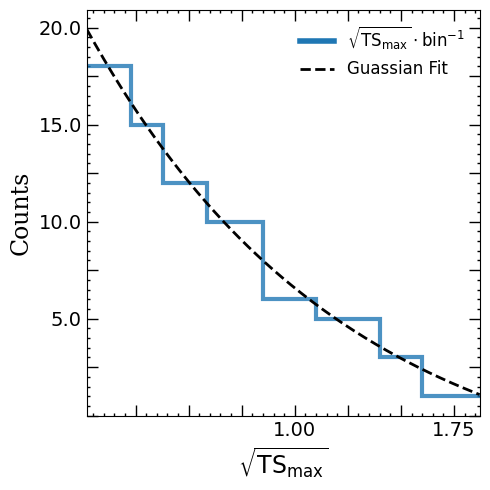

In [57]:
from matplotlib.lines import Line2D
font = {'family': 'serif',
        'weight': 'bold',
        'size': 22,
        'color':  'black',
        }
smallerfont = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 15,
        }

axesfont = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 17,
        }
custom_lines = [Line2D([0], [0], color='#1f77b4', lw=4),
                Line2D([0], [2],linestyle='--', color='k', lw=2)]
n_bins =11
# "[0.01747902 0.0178462  0.03233019 0.03303114 0.0354261  0.05503051
#  0.08652889 0.11939017 0.12909579 0.15410884 0.15476113 0.18331653
#  0.18775882 0.19666945 0.20035594 0.20293686 0.20597991 0.22560652
#  0.24190087 0.24536178 0.24573631 0.26567811 0.28534782 0.30723253
#  0.30968297 0.31159508 0.31345369 0.32502539 0.32632323 0.3341624
#  0.34315673 0.34680658 0.37246192 0.38716655 0.38953455 0.40447663
#  0.43822937 0.4492764  0.48808576 0.50409977 0.50896895 0.51897926
#  0.55949253 0.57870626 0.58776522 0.59480804 0.60468957 0.60972633
#  0.71654066 0.71754302 0.72647019 0.73171946 0.83064958 0.84597847
#  0.84679998 0.85469873 0.90901912 1.03573031 1.08611037 1.09485585
#  1.09623979 1.11963239 1.18179634 1.30774279 1.33038428 1.35292813
#  1.52959759 1.56236411 1.586236   2.14407672]"
fig, axs = plt.subplots(1, 1, tight_layout=True,figsize=(5, 5))
axs.set_ylabel('Counts',axesfont)
axs.set_xlabel(r'$\sqrt{{\rm TS_{max}}}$',axesfont)
# axs[1][0].set_ylabel('Counts',axesfont)
# axs[1][0].set_xlabel(r'$\sqrt{TS_{\rm max}}$',axesfont)

# N is the count in each bin, bins is the lower-limit of the bin
N, bins, patches = axs.hist(Ts_max_1, bins=[0.014,0.227, 0.38, 0.588, 0.85, 1.1, 1.4, 1.6, 2.145]   ,linewidth=3,histtype='step',stacked=True,alpha=0.8)
#print(bins,'\n',patches)
xdata=(bins[:-1]+bins[1:])*0.5
ydata=N
xplot=np.arange(min(xdata)-0.1,max(xdata),0.01)
axs.set_xlim(min(xdata)-0.1,max(xdata))
print(xdata,'\n',ydata)
# We'll color code by height, but you could use any scalar
parameters, covariance = curve_fit(gauss1, xdata, ydata,maxfev=5000000)
# parameters1,covariance1=curve_fit(gauss,xdata, ydata,maxfev=500000)
# fit_A = parameters[0]
# fit_B = parameters[1]

fit_y = gauss1(xplot, *parameters)

# axs[0].plot(xplot, fit_y, '--', label='fit',c='green')
axs.plot(xplot, fit_y,linestyle='--',c='k',linewidth=2)
# axs[1][0].errorbar(xdata, ydata, xerr=np.sqrt(xdata), yerr=np.sqrt(ydata), fmt='o', elinewidth=2,capsize=2)
# axs[1][0].plot(xplot, fit_y, '--', label='Guassian Fit',c='k',linewidth=1)
# fracs = N / N.max()

# we need to normalize the data to 0..1 for the full range of the colormap
# norm = colors.Normalize(fracs.min(), fracs.max())

# Now, we'll loop through our objects and set the color of each accordingly
# for thisfrac, thispatch in zip(fracs, patches):
#     color = plt.cm.viridis(norm(thisfrac))
#     thispatch.set_facecolor(color)

# We can also normalize our inputs by the total number of counts
# N1, bins1, patches1 = axs[0][1].hist(Ts_max, bins=n_bins, density=True)
# axs[0][1].set_ylabel('Counts density',axesfont)
# axs[0][1].set_xlabel(r'$\sqrt{TS_{\rm max}}$',axesfont)
# axs[1][1].set_ylabel('Counts density',axesfont)
# axs[1][1].set_xlabel(r'$\sqrt{TS_{\rm max}}$',axesfont)
# xdata1=(bins[:-1]+bins[1:])*0.5
# ydata1=N1
# xplot1=np.arange(min(xdata1)-0.00001,max(xdata1),0.1)
# parameters1,covariance1=curve_fit(gauss1,xdata1, ydata1,maxfev=500000)
# fit_y1=gauss1(xplot1, *parameters1)

# axs[0][1].plot(xplot1, fit_y1, '--', label='Guassian Fit',c='k',linewidth=2)
# axs[1][1].errorbar(xdata1, ydata1, xerr=np.sqrt(xdata1), yerr=np.sqrt(ydata1), fmt='o', elinewidth=2,capsize=2)
# axs[1][1].plot(xplot1, fit_y1, '--', label='Guassian Fit',c='k',linewidth=1)
# Now we format the y-axis to display percentage
#axs[1].yaxis.set_major_formatter(PercentFormatter(xmax=1))
axs.tick_params(which='major', width=1.5, length=6,direction='in')
axs.tick_params(which='minor', width=1.5, length=3,direction='in')
# axs[0][1].tick_params(which='major', width=1.5, length=6,direction='in')
# axs[0][1].tick_params(which='minor', width=1.5, length=3,direction='in')
# axs[1][0].tick_params(which='major', width=1.5, length=6,direction='in')
# axs[1][0].tick_params(which='minor', width=1.5, length=3,direction='in')
# axs[1][1].tick_params(which='major', width=1.5, length=6,direction='in')
# axs[1][1].tick_params(which='minor', width=1.5, length=3,direction='in')
# #axs[1].xaxis.set_minor_locator(MultipleLocator(5))
# axs[0][0].legend()
# # axs[1].xaxis.set_minor_locator(MultipleLocator(5))
# axs[0][1].legend()
axs.xaxis.set_minor_locator(AutoMinorLocator())
axs.yaxis.set_minor_locator(AutoMinorLocator())
axs.tick_params(which='minor', length=2,width=1, color='k')
axs.tick_params(which='major', length=8,width=1, color='k')
axs.tick_params(axis='x', which='minor', bottom=True,top=True)
axs.tick_params(axis='x', which='major', bottom=True,top=True)
axs.tick_params(axis='y', which='minor', bottom=True,top=True,right=True)
axs.tick_params(axis='y', which='major', bottom=True,top=True,right=True)
axs.set_xticklabels(['', '', '', '', '1.00', '', '', '1.75', ''], fontsize=14)  # Set size for x-axis
axs.set_yticklabels(['', '', '5.0', '', '10.0', '', '15.0', '', '20.0', ''], fontsize=14) 
# For the minor ticks, use no labels; default NullFormatter.
# axs[0][1].xaxis.set_minor_locator(AutoMinorLocator())
# axs[0][1].yaxis.set_minor_locator(AutoMinorLocator())
# axs[0][1].tick_params(which='minor', length=2, color='k')
# axs[1][0].xaxis.set_minor_locator(AutoMinorLocator())
# axs[1][0].yaxis.set_minor_locator(AutoMinorLocator())
# axs[1][0].tick_params(which='minor', length=2, color='k')
# axs[1][1].xaxis.set_minor_locator(AutoMinorLocator())
# axs[1][1].yaxis.set_minor_locator(AutoMinorLocator())
# axs[1][1].tick_params(which='minor', length=2, color='k')
# axs[1][0].set_xscale('log')
# axs[1][1].set_xscale('log')
# axs[1][0].set_yscale('log')
# axs[1][1].set_yscale('log')
# axs[0][0].set_yscale('log')
# axs[0][1].set_yscale('log')
# axs[0][0].set_xscale('log')
# axs[0][1].set_xscale('log')
x_labels = [tick.get_text() for tick in axs.get_xticklabels()]
y_labels = [tick.get_text() for tick in axs.get_yticklabels()]
print("X-axis tick labels:", x_labels)
print("Y-axis tick labels:", y_labels)
plt.legend(custom_lines,[r'$\sqrt{{\rm TS_{max}}} \cdot{\rm bin^{-1}}$','Guassian Fit'],fancybox=False,edgecolor=None,frameon=False,fontsize='large')
fig.savefig('fig2b.pdf')

In [219]:
def calc_chisquare(meas, sigma, fit): 
    diff = pow(meas-fit, 2.)
    print(diff)
    print(pow(sigma,2.))
    test_statistic = (diff/pow(sigma,2.)).sum()
    return test_statistic
chis = calc_chisquare(ydata, np.sqrt(ydata), gauss(xdata , *parameters))
NDF = len(ydata) - 3
print("chisquare/NDF = {0:.2f} / {1:d} = {2:.2f}".format(chis, NDF, chis / float(NDF)))

[0.04337348 0.64384145 0.28778396 1.3321205  1.92014747 0.00735255
 0.26622653]
[21. 17. 14. 10.  4.  3.  1.]
chisquare/NDF = 0.94 / 4 = 0.24


In [ ]:
# UNCOMMENT FOR LINEAR BINS
# all_enu = np.linspace(10**11.001, 10**18.999, 1000)
all_enu = e_nu_wall

# enus = 0.5*(all_enu[1:]+all_enu[:-1])
# UNCOMMENT FOR DENSER LOGARITHMIC BINS, optimal nbins is 1e6
enus = np.logspace(11.001, 18.999, int(1e6))
print(all_enu)
print (len(enus))


[1.00000000e+11 1.58489319e+11 2.51188643e+11 3.98107171e+11
 6.30957344e+11 1.00000000e+12 1.58489319e+12 2.51188643e+12
 3.98107171e+12 6.30957344e+12 1.00000000e+13 1.58489319e+13
 2.51188643e+13 3.98107171e+13 6.30957344e+13 1.00000000e+14
 1.58489319e+14 2.51188643e+14 3.98107171e+14 6.30957344e+14
 1.00000000e+15 1.58489319e+15 2.51188643e+15 3.98107171e+15
 6.30957344e+15 1.00000000e+16 1.58489319e+16 2.51188643e+16
 3.98107171e+16 6.30957344e+16 1.00000000e+17 1.58489319e+17
 2.51188643e+17 3.98107171e+17 6.30957344e+17 1.00000000e+18
 1.58489319e+18 2.51188643e+18 3.98107171e+18 6.30957344e+18
 1.00000000e+19]
1000000


# below are discarded

In [ ]:
gamma_arr = [-2, -2.2, -2.53, -3]
phio = np.logspace(-38, -26, 1000) #CHANGING TO LINEAR BINS RESULTS IN STRAIGHT LINES

# print("\nNumber of threads: ", num_threads)
print("\nNumber of energy bins: ", len(enus))
print("\nNumber of phi bins: ", len(phio))
print("\nCalculating weights...\n\n")


Number of energy bins:  1000000

Number of phi bins:  1000

Calculating weights...



In [ ]:
enus

array([1.00230524e+11, 1.00232370e+11, 1.00234216e+11, ...,
       9.97663317e+18, 9.97681690e+18, 9.97700064e+18])

In [ ]:
eareaa = [i.astype(np.float64) for i in earea]
eareaa = np.asfarray(eareaa, dtype=np.float64)
eareaa[0][0]
earea2 = np.asfortranarray(earea)
earea2 = earea2[0].astype(np.float64)

In [ ]:
print(msdec_bin_indices)

[47 32 48 ... 25 31 34]


In [ ]:
@vectorize(['float64(int64, float64, int64)'], nopython=True, target='parallel')
def psr_wt_sing_gamma(psrno,gamma, season):

    tt_upt = t_upt[season]
    l = msdec_bin_indices[psrno]
    wt_ac_temp = np.zeros(len(enus), dtype=np.float64)
    for i in prange(len(enus)):
        wt_ac_temp[i] = np.float64(tt_upt * earea[ea_season(season)][l*40 + enus_bin_indices[i]] * enus[i]**gamma)   


    return np.trapz(wt_ac_temp, enus)


In [ ]:
wt_vec = psr_wt_sing_gamma(range(p), -1, 0)
print(wt_vec)

[2.83650278e+13 5.86577806e+14 2.04760708e+13 ... 1.90869204e+16
 8.12870622e+14 3.75424443e+14]


In [ ]:
w_models = np.column_stack([np.ones(p), 1/(msdist**2), mss1400]).T.astype(np.float64)
sum_wt_model = [1, np.sum(1/(msdist**2)), np.sum(mss1400)]
print(w_models.shape)
print(sum_wt_model)

(3, 3389)
[1, inf, 5058.129999999999]


/tmp/ipykernel_2155/851389087.py:1: RuntimeWarning: divide by zero encountered in divide
  w_models = np.column_stack([np.ones(p), 1/(msdist**2), mss1400]).T.astype(np.float64)
/tmp/ipykernel_2155/851389087.py:2: RuntimeWarning: divide by zero encountered in divide
  sum_wt_model = [1, np.sum(1/(msdist**2)), np.sum(mss1400)]


In [ ]:


print(w_models.shape)
altier_path = [os.getcwd() + '/pickle/', os.getcwd() + '/../pickle/']
print(os.listdir(altier_path[0]))

(3, 3389)
['all_TSS_100000_bins_C_wt_all_psr_wmod1.pkl1', 'ns_hat_wt_wt_gamma_-1.txt', 'ns_hat_wt_wt_gamma_-2.2.txt', 'ns_all_ws_100000_bins_C_wt_all_psr_wmod1.pkl1', 'all_Si_ws_g_s_100000_bins_C_wt_all_psr_wmod1.pkl1', 'ns_hat_wt_wt_gamma_-2.5.txt', 'wt_acc_100000_bins_C_wt_all_psr_wmod1.pkl1', 'ns_hat_wt_wt_gamma_-3.txt', 'all_Bi.pkl']


In [ ]:
altier_path = [os.getcwd() + '/pickle/', os.getcwd() + '/../pickle/']
if f'wt_acc_{len(enus)}_bins.pkl' in os.listdir(altier_path[0]):# or f'wt_acc.pkl_{len(enus)}' in os.listdir(altier_path[1]):
    print("Loading wt_acc from pickle")
    # try:
    #     wt_acc = pickle.load(altier_path[1] + f'wt_acc.pkl_{len(enus)//2}_bins')
    # except:
    with open(altier_path[0] + f'wt_acc_{len(enus)}_bins.pkl', 'rb') as f:
        wt_acc = pickle.load(f)
    
    
    print("Loaded wt_acc from pickle with nbins= ", len(enus))

else:
    print("Calculating wt_acc for all pulsars and seasons and gamma")
    wt_acc = []
    for gamma in prange(len(gamma_arr)):
        wt_allpsr = []
        for season in tqdm(prange(10)):
            # tmp = []
            # for psrno in prange(p):
                # w_model = w_models[psrno]
                # tmp.append(psr_wt_sing_gamma(psrno, gamma_arr[gamma], season))
                # tmp.append(trapz_numba(psr_wt_sing_e_gamma(psrno, enus, gamma_arr[gamma], season), enus))

            wt_allpsr.append(np.array(psr_wt_sing_gamma(prange(p), gamma_arr[gamma], season), dtype=np.float64))
            # tmp = []
        wt_acc.append(wt_allpsr)
        wt_allpsr = []
        
    wt_acc = np.asfarray(wt_acc, dtype=np.float64)
    with open(altier_path[0] + f'wt_acc_{len(enus)}_bins.pkl', 'wb') as f:
        pickle.dump(wt_acc, f)
    print("Calculated wt_acc for all gamma-ray sources and seasons and gamma")

Loading wt_acc from pickle
Loaded wt_acc from pickle with nbins=  1000000


In [ ]:
print(wt_acc.shape)

(4, 10, 3389)


In [ ]:
season_walls = np.asarray([0, 36900, 143911, 237044, 373288, 486146, 608687, 735732, 865043, 988700, 1134450])
season_widts= np.diff(season_walls)
print (season_widts)

[ 36900 107011  93133 136244 112858 122541 127045 129311 123657 145750]


In [ ]:
#Compute the signal PDF for all neutrinos as per eqns 6, 7 and weights as per eqn 8 of 2205.15963

@njit(nogil=True)
def S_ijk(nu): 

    '''
    Calculates S_ij as in EQN 7 of 2205.15963
    ----------

    Parameters
    ----------
    nu : int
        Index of the neutrino in the sample
        
    
    Returns
    -------
        Returns the signal PDF for the {psrno}th pulsar and nuind_inp neutrino
    '''
    ang2 = hvovec(msra, msdec, icra[nu], icdec[nu], rad=True) ** 2      #rad**2
    sg = np.deg2rad(icang[nu]) ** 2                                     #rad**2
    return np.divide(np.exp(-1 * np.divide(ang2, 2*sg)), (2 * np.pi * sg))      #1/rad**2


@njit(nogil=True)
def S_ik(nu, weight, w_models, gamma_index, ws):

    '''
    
    Calculates S_i as in EQN 8 of 2205.15963
    ----------

    Parameters
    ----------
    nu : int
        Index of the neutrino in the sample

    normalized_wt : array
        Normalized weights of the pulsars


    gamma_index : int
        Index of the gamma value in the gamma array

    ws : int
        Index of the weight model

    Returns
    -------
        Returns the signal PDF for the {psrno}th pulsar and nuind_inp neutrino

    '''

    # si_sing_season_g =
    # for i in prange(p):
        # sij = S_ijk(nu)
        # np.sum(np.multiply(sij, normalized_wt[i][gamma_index][season]))      #1/rad**2



    sij = S_ijk(nu)
    season = 0
    for i in range(10):
        if season_walls[i] <= nu and nu < season_walls[i+1]:
            season = i
            break

    return np.sum(np.multiply(sij, np.multiply(w_models[ws], weight[gamma_index][season])/np.sum(np.multiply(w_models[ws], weight[gamma_index][season]))))      #1/rad**2


In [ ]:
@njit(parallel=True, nogil=True)
def Sik_sing_s_g(gamma_index, ws):#, wt_acc=wt_acc, w_models=w_models):
    '''
    Calculates S_i as in EQN 8 of 2205.15963
    ----------

    Parameters
    ----------
    weight : array
         weights of the pulsars

    season : int
        Season of the neutrino

    gamma_index : int
        Index of the gamma value in the gamma array

    ws : int
        Index of the weight model

    Returns
    -------
        Returns the signal PDF for the {psrno}th pulsar and nuind_inp neutrino
    '''



    tmp = []
    if ws == -1: #No weights
        for nu in prange(len(icra)):
            tmp.append(np.sum(S_ijk(nu)))
        return np.array(tmp, dtype=np.float64)

    for nu in prange(len(icra)):
        tmp.append(S_ik(nu, wt_acc, w_models, gamma_index, ws))
    return np.array(tmp, dtype=np.float64)

In [ ]:
#Pickle
if os.path.isfile(altier_path[0] + f'all_Si_ws_g_s_{len(enus)}_bins.pkl'):
    print("Loading all_Si_ws_g_s from pickle")
    with open(altier_path[0] + f'all_Si_ws_g_s_{len(enus)}_bins.pkl', 'rb') as f:
        all_Si_ws_g_s = pickle.load(f)
    print("Loaded all_Si_ws_g_s from pickle with nbins =", len(enus))
else:


    print("\nCalculating S_i for all neutrinos and gammas and weighting schemes...\n")

    all_Si_ws_g_s = []
    tmp = []
    tmp_wt_acc = []
    tmp_wt_acc_w_dist = []
    tmp_wt_acc_w_s1400 = []

    for gamma_index in tqdm(prange(4)):
        # for season in tqdm(prange(10)):
        tmp.append(Sik_sing_s_g(gamma_index, -1))
        tmp_wt_acc.append(Sik_sing_s_g(gamma_index, 0))
        tmp_wt_acc_w_dist.append(Sik_sing_s_g(gamma_index, 1))
        tmp_wt_acc_w_s1400.append(Sik_sing_s_g(gamma_index, 2))


    all_Si_ws_g_s.append([tmp, tmp_wt_acc, tmp_wt_acc_w_dist, tmp_wt_acc_w_s1400])
    tmp = []
    tmp_wt_acc = []
    tmp_wt_acc_w_dist = []
    tmp_wt_acc_w_s1400 = []
    all_Si_ws_g_s = np.asfarray(all_Si_ws_g_s[0])

    print("Calculated S_i for all neutrinos and gammas and weighting schemes")
    #Save to pickle
    with open(altier_path[0] + f'all_Si_ws_g_s_{len(enus)}_bins.pkl', 'wb') as f:
        pickle.dump(all_Si_ws_g_s, f)




Calculating S_i for all neutrinos and gammas and weighting schemes...


100%|██████████| 4/4 [05:33<00:00, 83.37s/it]

Calculated S_i for all neutrinos and gammas and weighting schemes


In [ ]:
# @jit(nopython=True)
@vectorize(['float64(int64, int64)'], nopython=True,target='parallel')
def Bi_single_compute(nu,i,cone=5):

    '''
    Calculates B_i as in EQN 9 of 2205.15963
    ----------

    Parameters
    ----------
    nu : int
        Index of the neutrino from IceCube sample
    cone : float
        Cone angle in degrees.
    

    Returns
    -------
    float
        Returns the background PDF for the {nu}th neutrino
    '''

    # count = np.sum(np.abs(np.subtract(icdec, icdec[nu])) <= cone)
    count=0
    for i in prange(len(icdec)):
        if abs(icdec[i] - icdec[nu]) <= cone:
            count+=1
    binwidth = (np.sin(np.deg2rad(icdec[nu] + cone)) - np.sin(np.deg2rad(icdec[nu] - cone)))*2*np.pi
    return count/(binwidth * N_ic)           #No units or sr**-1

In [ ]:
#Pickle
if os.path.isfile(altier_path[0] + f'all_Bi.pkl'):
    print("Loading all_Bi from pickle...")
    with open(altier_path[0] + f'all_Bi.pkl', 'rb') as f:
        all_Bi = pickle.load(f)
    print("Loaded all_Bi from pickle")
else:
    print("\nCalculating Bi for all neutrinos\n")
    all_Bi = Bi_stacked_compute(np.arange(lnu), 5)
    # all_Bi+=1e-90
    print("\nCalculated Bi for all neutrinos")
    #Save to pickle
    with open(altier_path[0] + f'all_Bi.pkl', 'wb') as f:
        pickle.dump(all_Bi, f)

Loading all_Bi from pickle...
Loaded all_Bi from pickle


 '''
    This function returns the number of signal events for a single pulsar as in EQN3 of 2205.15963
    -------------------

    Parameters
    ----------
    dec : float
        The declination of the pulsar in radians
    
    enu : float
        The neutrino energy in eV

    gamma : float
        The spectral index of the neutrino flux

    phi0 : float (optional)
        The normalization constant of the neutrino flux

    season : int (optional)
        The IceCube season number
    
    Returns
    -------
    float
        The number of signal events for the given parameters
    '''


In [ ]:
type(msdec_bin_indices[0])

numpy.int64

In [ ]:
arr = np.zeros(10, dtype=np.float64)

In [ ]:
t_upt

array([35318439.34329611, 32497618.3151043 , 29902901.99932829,
       31745765.00015999, 32053797.00057632, 33098838.99984006,
       34788962.99980783, 33936928.00012794, 31302372.99945645,
       36107635.00003202])

In [ ]:
#generates ns^ for a single pulsar a single season and a single energy


# @vectorize(['float64(int64, float64, int64)'], nopython=True, target='parallel')
# def psr_wt_sing_gamma(psrno,gamma, season):

#     tt_upt = t_upt[season]
#     l = msdec_bin_indices[psrno]
#     wt_ac_temp = np.zeros(len(enus), dtype=np.float64)
#     for i in prange(len(enus)):
#         wt_ac_temp[i] = np.float64(tt_upt * earea[ea_season(season)][l*40 + enus_bin_indices[i]] * enus[i]**gamma)


#     return np.trapz(wt_ac_temp, enus)
# @njit
# @vectorize(['float64(float64, float64, float64, int64)'], target='parallel')
@vectorize(['float64(int64, float64, float64, int64)'], nopython=True, target='parallel')
def ns_singleseason_sing_psr_HAT(psrno,gamma, phi0, season):
   

    tt_upt = t_upt[season]
    # if enu <= 1e11 or enu >= 1e19:
    #     return 0.0
    # else:
        # k=0
    l = msdec_bin_indices[psrno]
        # for i in range(0, len(e_nu_wall)):
        #     if e_nu_wall[i] <= enu and e_nu_wall[i+1] > enu:
        #         k=i
        #         break

        # for j in range(0, len(dec_nu)):
        #     if dec_nu[j] <= dec and dec_nu[j+1] > dec:
        #         l=j
        #         break
    ns_temp = np.zeros(len(enus), dtype=np.float64)
    for i in prange(len(enus)):
        ns_temp[i] += np.float64(tt_upt * earea[ea_season(season)][l*40 + enus_bin_indices[i]] * phi0 * (enus[i]/(10**14))**gamma)
    # temp_ea = np.asarray(earea[ea_season(season)])[l*40 + k]
    # return tt_upt * temp_ea * phi0 * ((enu/(10**14))**gamma)     #in s cm2 eV

    return np.trapz(ns_temp, enus)     #in s cm2 eV


In [ ]:
msdec

array([62.26927778, 47.77594444, -9.16630556, ..., -6.16663861,
       61.92967917,  0.85265833])

In [ ]:
def ns_HAT_all_season_all_psr_sing_gamma_wt_wtht_weights(gamma, e_nus=enus, phi0=1):
    ns_hat = 0
    ns_hat_wt = 0
    ns_hat_wt_dist = 0
    ns_hat_wt_s1400 = 0
    for season in tqdm(prange(10)):
        # for psr in prange(p):
            # wt = all_weights[0][gamma_arr.index(gamma)][psr][ea_season(season)]
        wt_sum = np.sum(wt_acc[gamma_arr.index(gamma)][season])

        wt = wt_acc[gamma_arr.index(gamma)][season]
        ns_hat = ns_singleseason_sing_psr_HAT(prange(p), gamma, phi0, season)
        # ns_hat_wt += np.dot(wt, nsop)
        # ns_hat_wt_dist += np.dot(wt/msdist[prange(p)]**2, nsop)
            # nsop = ns_singleseason_sing_psr_HAT(msdec[psr], e_nus, gamma, phi0, season)
            
            # ns_hat += np.trapz(nsop, x=e_nus)
        
    #         ns_hat_wt += wt * np.trapz(nsop, x=e_nus)
    #         ns_hat_wt_dist += wt * np.trapz(nsop, x=e_nus) / (msdist[psr]**2)
    #         ns_hat_wt_s1400 += wt * np.trapz(nsop, x=e_nus) * mss1400[psr]
    # return np.array([ns_hat, ns_hat_wt, ns_hat_wt_dist, ns_hat_wt_s1400], dtype=np.float64)

        ns_hat_wt += np.dot((wt/wt_sum),  ns_hat)
        ns_hat_wt_dist += np.dot(wt * w_models[1]/ np.sum(np.multiply(wt_acc[gamma_arr.index(gamma)][season], w_models[1])) , ns_hat)
        ns_hat_wt_s1400 += np.dot(wt * w_models[2]/ np.sum(np.multiply(wt_acc[gamma_arr.index(gamma)][season], w_models[2])), ns_hat)
    return np.array([np.sum(ns_hat), ns_hat_wt, ns_hat_wt_dist, ns_hat_wt_s1400], dtype=np.float64)

In [ ]:
#Pickle
arr = []
if os.path.isfile(altier_path[0] + f'ns_all_ws_{len(enus)}_bins.pkl'):
    print("Loading ns_hat from pickle...")
    with open(altier_path[0] + f'ns_all_ws_{len(enus)}_bins.pkl', 'rb') as f:
        arr = pickle.load(f)
    print("Loaded ns_hat from pickle with nbins =", len(enus))
else:
    print("\nCalculating ns_HAT for all gamma and weighting schemes...\n")

    arr=[]
    for gamma in prange(len(gamma_arr)):
        tmp = ns_HAT_all_season_all_psr_sing_gamma_wt_wtht_weights(gamma_arr[gamma])
        np.savetxt('outputs/ns_hat_wt_wt_gamma_{}.txt'.format(gamma_arr[gamma]), tmp)
        arr.append(tmp)
        tmp = []

    arr = np.array(arr, dtype=np.float64)
    with open(altier_path[0] + f'ns_all_ws_{len(enus)}_bins.pkl', 'wb') as f:
        pickle.dump(arr, f)
    print("\nCalculationed ns_HAT for all gamma and weighting schemes")


Calculating ns_HAT for all gamma and weighting schemes...


  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_2155/2468739112.py:25: RuntimeWarning: invalid value encountered in divide
  ns_hat_wt_dist += np.dot(wt * w_models[1]/ np.sum(np.multiply(wt_acc[gamma_arr.index(gamma)][season], w_models[1])) , ns_hat)
100%|██████████| 10/10 [03:43<00:00, 22.34s/it]


Calculationed ns_HAT for all gamma and weighting schemes


In [ ]:
arr

array([[3.52864701e+31, 1.64348155e+29,            nan, 1.43286227e+29],
       [4.29254469e+31, 2.12101932e+29,            nan, 1.97836837e+29],
       [9.09734829e+31, 4.71885376e+29,            nan, 4.68667418e+29],
       [4.99686265e+32, 2.64971787e+30,            nan, 2.73604535e+30]])

In [ ]:
@njit(parallel=True, nogil=True)
def season_nu(nu):
    for i in prange(10):
        if nu >= season_walls[i] and nu < season_walls[i+1]:
            return i

t2mp = all_Si_ws_g_s[0][0]
nsa = 50
@njit(nogil=True)
def TS_for_all_psrs2(nsa):  
    return Ts_arr2(nsa, t2mp, all_Bi, Ns) 

TS_for_all_psrs2(nsa)

In [ ]:
@jit(nopython=True)
def Pr(x, Ns, S, B):
    nsN = x/Ns
    return np.add(np.multiply(nsN , S), np.multiply(np.subtract(1, nsN), B))



@njit(nogil=True)
def TS_st_vec(x, S, B, Ns):
    nsN = x/Ns
    pr = np.add(np.multiply(nsN , S), np.multiply(np.subtract(1, nsN), B))
    return np.sum(np.asfarray(2*np.log(pr/B)))

lnu = 1134450
Ns = lnu#np.count_nonzero(nuind+1)


TS_st_vec(0.5e6, all_Si_ws_g_s[0][0], all_Bi, Ns)